In [755]:
import pandas as pd
import json
import numpy as np
import statistics
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [756]:
df = pd.read_csv('data/Experiment_Result.csv')
df.head()
df.columns

Index(['Unnamed: 0', 'block', 'browser', 'color', 'cookies', 'correct',
       'cpt_response', 'current_time', 'inter_stimulus_interval_index',
       'inter_stimulus_interval_time', 'is_fullscreen', 'key_press', 'mobile',
       'os', 'response', 'responses', 'rt', 'shape', 'stimulus',
       'stimulus_block', 'stimulus_side', 'sub_block', 'subject', 'tags1',
       'tags2', 'time_elapsed', 'time_post_trial', 'trial_began',
       'trial_index', 'trial_type', 'type', 'stimulus_missed'],
      dtype='object')

In [757]:
print('Not fullscreen:', df[df.is_fullscreen == False].shape)

Not fullscreen: (0, 32)


In [758]:
df.drop(df[~df['inter_stimulus_interval_index'].isnull()].index)
df.drop(df.loc[(df['trial_type'] == 'survey-text') &
        (~df['color'].isnull())].index, inplace=True)
df.drop(df.loc[(df['trial_type'] == 'survey-text') &
        (~df['cpt_response'].isnull())].index, inplace=True)
df.drop(df.loc[(df['trial_type'] == 'survey-multi-choice')
        & (~df['color'].isnull())].index, inplace=True)
df.drop(df.loc[(df['trial_type'] == 'survey-multi-choice') &
        (~df['cpt_response'].isnull())].index, inplace=True)
df.drop(df.loc[(df['trial_type'] == 'survey-likert') &
        (~df['color'].isnull())].index, inplace=True)
df.drop(df.loc[(df['trial_type'] == 'survey-likert') &
        (~df['cpt_response'].isnull())].index, inplace=True)
df['current_time'] = pd.to_numeric(df['current_time'])


In [759]:
last_time = -1
last_index = -1
lst = []
for index, row in df.iterrows():
    if row.trial_type != 'conjunctive-cpt':
        last_index = -1
        continue
    if row.current_time < last_time:
        lst.append(last_index)
    else:
        last_index = index
    last_time = row.current_time
print(len(lst))


4235


In [760]:
print(df.shape)
df.drop(lst, inplace=True)
print(df.shape)

(43494, 32)
(39259, 32)


In [761]:
df.drop(df.loc[df['trial_type'] == 'instructions'].index, inplace=True)

In [762]:
count = 0
df_lst = []
bad_boys_lst = []
peoples_lst = []
one_df = pd.DataFrame()
for index, row in df.iterrows():
    if row['Unnamed: 0'] == 1 and not one_df.empty:
        brms_df = one_df[(one_df.trial_type == 'bRMS') &
                         (one_df.stimulus_block != "training")]
        brms_missed = brms_df[((brms_df.key_press != 'P') & (brms_df.stimulus_side == 0)) | (
            (brms_df.key_press != 'Q') & (brms_df.stimulus_side == 1))]
        if brms_missed.shape[0] / 60 < 0.15:
            df_lst.append(one_df.copy())
        else:
            bad_boys_lst.append(one_df.copy())
        peoples_lst.append(brms_missed.shape[0] / 60)
        one_df = pd.DataFrame()
    one_df = one_df.append(row)


In [763]:
def shaming():
    for bad_boy in bad_boys_lst:
        brms_df = bad_boy[(bad_boy.trial_type == 'bRMS') &
                          (bad_boy.stimulus_block != "training")]

        print(brms_df.groupby(by=['key_press']).trial_type.count())
        plt.xlabel('rt')
        plt.ylabel('count')
        plt.hist(brms_df.rt, bins=100)
        plt.show()
    peoples = {'Shit': 0, 'Stupid': 0, 'Decent': 0}
    for one in peoples_lst:
        if one >= 0.45:
            peoples['Shit'] += 1
        elif one >= 0.15:
            peoples['Stupid'] += 1
        else:
            peoples['Decent'] += 1
    print(peoples)


In [764]:
df.groupby(['trial_type']).size()

trial_type
bRMS                    3150
conjunctive-cpt        34724
survey-likert            450
survey-multi-choice      360
survey-text              225
dtype: int64

In [765]:
cpt_training_options = [6, 13, 78, 85]
cpt_options = [8, 15, 80, 87]
asrs_options = [6, 10, 78, 82]

values = {
    "age": 2,
    "brms_understood": [88],
    "brms_stratagy_exist": [89],
    "brms_stratagy": [90],
    "cpt_understood": [91],
    "cpt_stratagy_exist": [92],
    "cpt_stratagy": [93],
    "your_driving": [94],
    "accedint_driver": [95],
    "accedint_walker": [96],
    "hps1": [98],
    "hps2": [99],
    "hps3": [100],
    "hps4": [101],
}

In [766]:
def word_to_bool(x):
    if type(x) == str:
        if str.lower(x) in ['כן', 'ימין','נכון', 'אישה']:
            return 1
        else:
            return 0
    else:
        return x

In [767]:
def get_hps_count(single_df):
    count = 0
    for i in range(98, 102):
        answer_df = single_df[(single_df.trial_index == i)
                              & (~single_df.responses.isnull())].responses
        obj = json.loads(answer_df.iloc[0])
        count += word_to_bool(obj.get('Q0')) + \
            word_to_bool(obj.get('Q1')) + word_to_bool(obj.get('Q2'))
    return count


In [768]:
def get_asrs_start(single_df):
    for option in asrs_options:
        asrs_1 = single_df[(single_df.trial_index == option)
                           & (~single_df.responses.isnull())]
        if not asrs_1.empty:
            return option


In [769]:
def get_asrs_answers(single_df):
    start_asrs = get_asrs_start(single_df)
    asrs_1_df = single_df[(single_df.trial_index == start_asrs) & (
        ~single_df.responses.isnull())].responses

    asrs_1_obj = json.loads(asrs_1_df.iloc[0])
    asrs_1 = asrs_1_obj.get('Q0')
    asrs_2 = asrs_1_obj.get('Q1')
    asrs_3 = asrs_1_obj.get('Q2')

    asrs_2_df = single_df[(single_df.trial_index == start_asrs + 1)
                          & (~single_df.responses.isnull())].responses
    asrs_2_obj = json.loads(asrs_2_df.iloc[0])
    asrs_4 = asrs_2_obj.get('Q0')
    asrs_5 = asrs_2_obj.get('Q1')
    asrs_6 = asrs_2_obj.get('Q2')

    asrs_3_df = single_df[(single_df.trial_index == start_asrs + 2)
                          & (~single_df.responses.isnull())].responses
    obj = json.loads(asrs_3_df.iloc[0])
    asrs_7 = obj.get('Q0')
    asrs_8 = obj.get('Q1')
    asrs_9 = obj.get('Q2')

    asrs_4_df = single_df[(single_df.trial_index == start_asrs + 3)
                          & (~single_df.responses.isnull())].responses
    obj = json.loads(asrs_4_df.iloc[0])
    asrs_10 = obj.get('Q0')
    asrs_11 = obj.get('Q1')
    asrs_12 = obj.get('Q2')

    asrs_5_df = single_df[(single_df.trial_index == start_asrs + 4)
                          & (~single_df.responses.isnull())].responses
    obj = json.loads(asrs_5_df.iloc[0])
    asrs_13 = obj.get('Q0')
    asrs_14 = obj.get('Q1')
    asrs_15 = obj.get('Q2')

    asrs_6_df = single_df[(single_df.trial_index == start_asrs + 5)
                          & (~single_df.responses.isnull())].responses
    obj = json.loads(asrs_6_df.iloc[0])
    asrs_16 = obj.get('Q0')
    asrs_17 = obj.get('Q1')
    asrs_18 = obj.get('Q2')

    sum_part_one = asrs_1 + asrs_2 + asrs_3 + asrs_4 + asrs_5 + asrs_6
    sum_part_two = asrs_7 + asrs_8 + asrs_9 + asrs_10 + asrs_11 + \
        asrs_12 + asrs_13 + asrs_14 + asrs_15 + asrs_16 + asrs_17 + asrs_18

    return [sum_part_one, sum_part_two]


In [770]:
def get_values(single_df):
    lst = []
    for key, value in values.items():
        currnet = single_df[(single_df.trial_index == value[0]) & (~single_df.responses.isnull())].responses
        print(currnet.empty, value[0])
        obj = json.loads(currnet.iloc[0])
        if len(obj.keys()) > 1:
            for i in range(len(obj.keys())):
                lst.append(obj.get('Q' + str(i)))
        else:   
            lst.append(obj.get('Q0'))
    return lst

In [771]:
def is_cpt_stimulus(cpt_df):
    return cpt_df['shape'] == 'square' and cpt_df['color'] == '#FF0000'

In [772]:
def get_cpt_df(single_df):
    cpt_df = single_df[single_df.trial_type == 'conjunctive-cpt']
    trial_types = cpt_df.trial_index.unique()
    cpt_df = cpt_df[cpt_df.trial_index == trial_types[1]]
    cpt_df['is_cpt_stimulus'] = cpt_df.apply(is_cpt_stimulus, axis=1)
    cpt_df = cpt_df[(cpt_df.is_cpt_stimulus == True) | (cpt_df.cpt_response == 1)]
    return cpt_df

In [773]:
def get_clean_cpt_df(single_df):
    cpt_df = get_cpt_df(single_df)
    rapid_cpt_response_indexes = []
    last_is_response = False
    count = 0
    for index, row in cpt_df.iterrows():
        if row.trial_type != 'conjunctive-cpt':
            continue
        elif row.cpt_response == 1:
            if last_is_response:
                count += 1
                rapid_cpt_response_indexes.append(index)
            else:
                last_is_response = True
        else:
            last_is_response = False
    cpt_df.drop(rapid_cpt_response_indexes, inplace=True)
    return cpt_df


In [774]:
def get_cpt_result_df(single_df):
    cpt_df = get_clean_cpt_df(single_df)
    cpt_df.to_csv('cpt_df.csv')
    cpt_df['cpt_response_time']  = cpt_df['current_time'].diff()
    cpt_df['cpt_response_time']  = cpt_df[cpt_df.cpt_response_time > 0.1].cpt_response_time
    cpt_df['cpt_response_time'] = np.log(cpt_df['cpt_response_time'])
    return cpt_df

In [775]:
def get_cpt_resuslt(single_df):
    cpt_df = get_cpt_result_df(single_df)
    return cpt_df['cpt_response_time']


In [794]:
def get_standards_cpt_result(single_df):
    cpt_result = get_cpt_result_df(single_df)
    cpt_result_mean = cpt_result.cpt_response_time.mean()
    cpt_result_std = cpt_result.cpt_response_time.std()
    cpt_standard_df = cpt_result[(cpt_result.cpt_response_time > cpt_result_mean - 3 * cpt_result_std) & (cpt_result.cpt_response_time < cpt_result_mean + 3 * cpt_result_std)]    
    return cpt_standard_df.cpt_response_time

In [777]:
def get_age(single_df):
    age_df = single_df[single_df.trial_index == 2].responses
    return json.loads(age_df.iloc[0]).get("Q0")

In [778]:
def get_q1_answers(single_df):
    q1_df = single_df[single_df.trial_index == 1].responses
    q1_obj = json.loads(q1_df.iloc[0])
    return [q1_obj.get('Q0'), q1_obj.get('Q1'), q1_obj.get('Q2')]

In [779]:
def get_one_value(single_df, index):
    try:
        value_df = single_df[single_df.trial_index == index].responses
        return json.loads(value_df.iloc[0]).get("Q0")
    except:
        return ''


In [780]:
def get_brms_df(single_df):
    brms_df = single_df[(single_df.trial_type == 'bRMS') &
                        (single_df.stimulus_block != "training")]
    brms_df = brms_df[~(((brms_df.key_press != 'P') & (brms_df.stimulus_side == 0)) | (
        (brms_df.key_press != 'Q') & (brms_df.stimulus_side == 1)))]
    brms_df = brms_df[(brms_df.rt < 8000) & (brms_df.rt > 100)]
    brms_df['rt'] = np.log(brms_df.rt)
    return brms_df


In [781]:
def get_rms_standards(brms_df):
    mean_rt = brms_df.rt.mean()
    std_rt = brms_df.rt.std()
    brms_standard_df = brms_df[(brms_df.rt > mean_rt - 3 * std_rt) & (brms_df.rt < mean_rt + 3 * std_rt)]    
    return brms_standard_df
    

In [816]:
def get_rms_values(single_df):
    brms_df = get_rms_standards(get_brms_df(single_df))
    rt_blocks_mean = brms_df.groupby('stimulus_block').rt
    blocks_rt = rt_blocks_mean.apply(list)
    return [brms_df.rt.mean(), brms_df.rt.std(), 
            statistics.mean(blocks_rt[0]), statistics.mean(blocks_rt[1]), statistics.mean(blocks_rt[2]), statistics.mean(blocks_rt[3]),
            brms_df.stimulus_block, brms_df.shape[0]]


In [815]:
for single_df in df_lst:
    get_rms_values(single_df)

stimulus_block
high_face           [7.407681720953566, 6.972793675876257, 7.68105...
high_face_revert    [7.402512494801653, 7.495486386573494, 7.21435...
low_face            [7.641612447972995, 7.179079283948638, 7.34349...
low_face_revert     [7.343749592125124, 7.2258453076053, 7.4739209...
Name: rt, dtype: object
stimulus_block
high_face           [7.594381242551817, 7.347106383043343, 7.41589...
high_face_revert    [7.316415277955133, 7.316813922584594, 7.50845...
low_face            [8.031157736480724, 7.259538276857213, 7.20310...
low_face_revert     [7.509170868968622, 7.239645606115347, 7.90835...
Name: rt, dtype: object
stimulus_block
high_face           [7.0707241072602764, 7.271842681841153, 7.2835...
high_face_revert    [7.314952218919568, 7.27010409522012, 7.372118...
low_face            [7.199304862960407, 7.285986214659201, 7.61189...
low_face_revert     [7.351735723073931, 7.407196344575997, 7.55700...
Name: rt, dtype: object
stimulus_block
high_face           [7.22642

In [817]:
def get_rms_histogram_real_vs_standards():
    for single_df in df_lst:
        brms_df = get_brms_df(single_df)
        brms_standard_df = get_rms_standards(brms_df)
        
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

        axes[0].set_xlabel('rt')
        axes[0].set_ylabel('count')
        axes[0].hist(brms_df.rt, bins=100)

        axes[1].set_xlabel('rt standard')
        axes[1].set_ylabel('count')
        axes[1].hist(brms_standard_df.rt, bins=100)
        plt.show()


In [784]:
def get_rms_without_errors(single_df):
    pass

In [818]:
def get_result_df():
    result_df = pd.DataFrame()
    for df_current in df_lst:
        rms_anwers = get_rms_values(df_current)
        cpt_response = get_standards_cpt_result(df_current)
        stimulus_missed = df_current[~df_current.stimulus_missed.isnull()].shape[0]
        asrs_answers = get_asrs_answers(df_current)
        q1_answers = get_q1_answers(df_current)
        result_df = result_df.append(
            {
                #'age': get_one_value(df_current, 2),
                #'gender': q1_answers[0],
                #'strong_hand': q1_answers[1],
                #'main_lang': q1_answers[2],
                #'adhd': get_one_value(df_current, 3),
                #'feel_adhd': get_one_value(df_current, 4),
                'brms_rt_mean': rms_anwers[0],
                'brms_rt_mean_std': rms_anwers[1],
                'brms_rt_mean_high': rms_anwers[2],
                'brms_rt_mean_high_reverted': rms_anwers[3],
                'brms_rt_mean_low': rms_anwers[4],
                'brms_rt_mean_low_reverted': rms_anwers[5],
                #'brms_trial_count': rms_anwers[6],
                #'asrs_1_count': asrs_answers[0],
                'asrs_count': asrs_answers[1] + asrs_answers[0],
                'asrs_high_adhd': asrs_answers[0] >= 24 or asrs_answers[1] >= 24,
                # 'asrs_med_adhd': 17 <= asrs_answers[0] < 24 or 17 <= asrs_answers[1] < 24,
                'cpt_response_mean': cpt_response.mean(),
                'cpt_response_mean_std': cpt_response.std(),
                'cpt_misses': stimulus_missed,
                'hps_count': get_hps_count(df_current),
                # "brms_understood": get_one_value(df_current, 88),
                # "brms_stratagy_exist": get_one_value(df_current, 89),
                # "brms_stratagy": get_one_value(df_current, 90),
                # "cpt_understood": get_one_value(df_current, 91),
                # "cpt_stratagy_exist": get_one_value(df_current, 92),
                # "cpt_stratagy": get_one_value(df_current, 93),
                # "your_driving": get_one_value(df_current, 94),
                # "accedint_driver": get_one_value(df_current, 95),
                # "accedint_walker": get_one_value(df_current, 96),
            }, ignore_index=True)
    
    return result_df

In [819]:
result_df = get_result_df()

In [787]:
result_df.to_csv('result.csv')

In [788]:
def tanslate_heb(value):
    if value == 'אישה':
        return 'Female'
    elif value == 'גבר':
        return "Male"
    elif value == 'ימין':
        return 'Right'
    elif value == 'שמאל':
        return 'Left'
    elif value == 'נכון':
        return 'True'
    elif value == 'לא נכון':
        return 'False'
    elif value == 'כן':
        return 'Yes'
    elif value == 'לא':
        return 'No'
    else:
        return value

In [789]:
def fix_heb_columns(df):
    result_df['feel_adhd'] = pd.to_numeric(result_df['feel_adhd'])
    result_df['age'] = pd.to_numeric(result_df['age'])
    result_df['strong_hand'] = result_df['strong_hand'].apply(tanslate_heb)
    result_df['main_lang'] = result_df['main_lang'].apply(tanslate_heb)
    result_df['gender'] = result_df['gender'].apply(tanslate_heb)

In [821]:
result_df.corr()

,brms_rt_mean,brms_rt_mean_std,brms_rt_mean_high_reverted,brms_rt_mean_low,brms_rt_mean_low_reverted,asrs_count,asrs_high_adhd,cpt_response_mean,cpt_response_mean_std,cpt_misses,hps_count
brms_rt_mean,1.000000,0.784887,0.967525,0.948587,0.935758,0.041701,0.131524,0.056552,0.162619,0.100200,0.029816
brms_rt_mean_std,0.784887,1.000000,0.742725,0.807419,0.711011,-0.041600,0.031906,0.120208,0.055515,0.051783,-0.055005
brms_rt_mean_high_reverted,0.967525,0.742725,1.000000,0.881802,0.931430,0.099844,0.164916,0.083292,0.092696,0.083055,0.026592
brms_rt_mean_low,0.948587,0.807419,0.881802,1.000000,0.819367,-0.018899,0.120902,0.073710,0.171839,0.106762,-0.019689
brms_rt_mean_low_reverted,0.935758,0.711011,0.931430,0.819367,1.000000,0.165858,0.218953,0.110303,0.114168,0.193457,0.116967
asrs_count,0.041701,-0.041600,0.099844,-0.018899,0.165858,1.000000,0.732314,0.176421,-0.290034,0.090093,0.558095
asrs_high_adhd,0.131524,0.031906,0.164916,0.120902,0.218953,0.732314,1.000000,0.221378,-0.155595,0.206623,0.543751
cpt_response_mean,0.056552,0.120208,0.083292,0.073710,0.110303,0.176421,0.221378,1.000000,-0.610411,0.574500,0.141849
cpt_response_mean_std,0.162619,0.055515,0.092696,0.171839,0.114168,-0.290034,-0.155595,-0.610411,1.000000,-0.169175,-0.247092
cpt_misses,0.100200,0.051783,0.083055,0.106762,0.193457,0.090093,0.206623,0.574500,-0.169175,1.000000,-0.049900


In [799]:
rho = result_df.corr()
pval = result_df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t]))
rho.round(2).astype(str) + p

,brms_rt_mean,brms_rt_mean_std,asrs_count,asrs_high_adhd,cpt_response_mean,cpt_response_mean_std,cpt_misses,hps_count
brms_rt_mean,1.0***,0.78***,0.04,0.13,0.06,0.16,0.1,0.03
brms_rt_mean_std,0.78***,1.0***,-0.04,0.03,0.12,0.06,0.05,-0.06
asrs_count,0.04,-0.04,1.0***,0.73***,0.18,-0.29*,0.09,0.56***
asrs_high_adhd,0.13,0.03,0.73***,1.0***,0.22,-0.16,0.21,0.54***
cpt_response_mean,0.06,0.12,0.18,0.22,1.0***,-0.61***,0.57***,0.14
cpt_response_mean_std,0.16,0.06,-0.29*,-0.16,-0.61***,1.0***,-0.17,-0.25
cpt_misses,0.1,0.05,0.09,0.21,0.57***,-0.17,1.0***,-0.05
hps_count,0.03,-0.06,0.56***,0.54***,0.14,-0.25,-0.05,1.0***


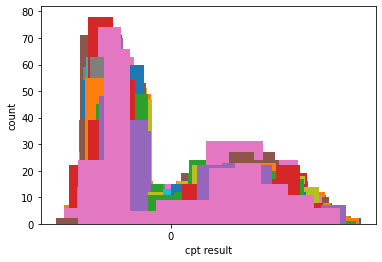

In [792]:
all_df = []
for single_df in df_lst:
    cpt_result = get_standards_cpt_result(single_df)
    all_df.append(cpt_result)
    plt.xlabel("cpt result")
    plt.xticks(np.arange(0, 10000, 250))
    plt.ylabel("count")
    plt.hist(cpt_result.cpt_response_time)
    # plt.show()


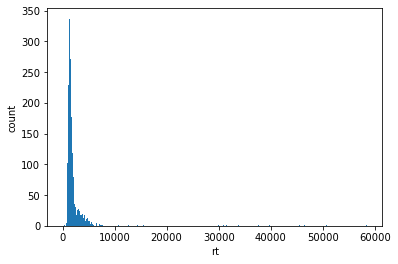

ValueError: not enough values to unpack (expected 6, got 4)

In [793]:
brms_df = df[(df.trial_type == 'bRMS') & (
    df.stimulus_block != "training")]

rt = brms_df.rt.values.reshape(-1, 1)
plt.xlabel("rt")
plt.ylabel("count")
plt.hist(rt, bins=500)
plt.show()

for single_df in df_lst:
    brms_df = single_df[
        (single_df.trial_type == 'bRMS') &
        (single_df.stimulus_block != "training") &
        ~(((single_df.key_press != 'P') & (single_df.stimulus_side == 0)) |
        ((single_df.key_press != 'Q') & (single_df.stimulus_side == 1)))
    ]
    brms_rt_mean, brms_rt_mean_sd, brms_missed, brms_stimulus_block, brms_rt_diff_mean, brms_rt_diff_mean_sd = get_rms_values(
        single_df)
    if brms_missed / 60 > 0.2:
        continue
    rt = brms_df.rt.values.reshape(-1, 1)
    plt.xlabel("rt")
    plt.xticks(np.arange(0, 10000, 250))
    plt.ylabel("count")
    plt.hist(rt, bins=50)
    plt.show()


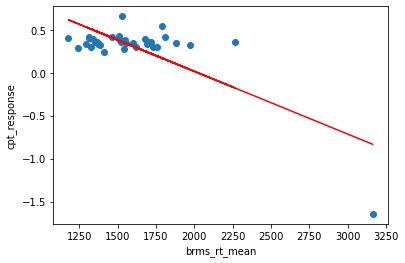

In [ ]:
from sklearn.linear_model import LinearRegression

X = result_df.brms_rt_mean.values.reshape(-1, 1)
Y = result_df.cpt_response_mean.values.reshape(-1, 1)
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)

plt.xlabel("brms_rt_mean")
plt.ylabel("cpt_response")
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()


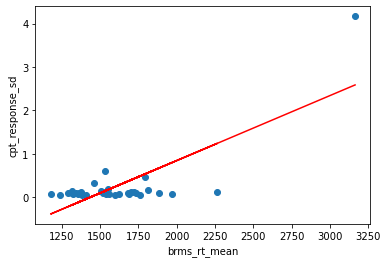

In [ ]:
from sklearn.linear_model import LinearRegression

X = result_df.brms_rt_mean.values.reshape(-1, 1)
Y = result_df.cpt_response_sd.values.reshape(-1, 1)
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)

plt.xlabel("brms_rt_mean")
plt.ylabel("cpt_response_sd")
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()


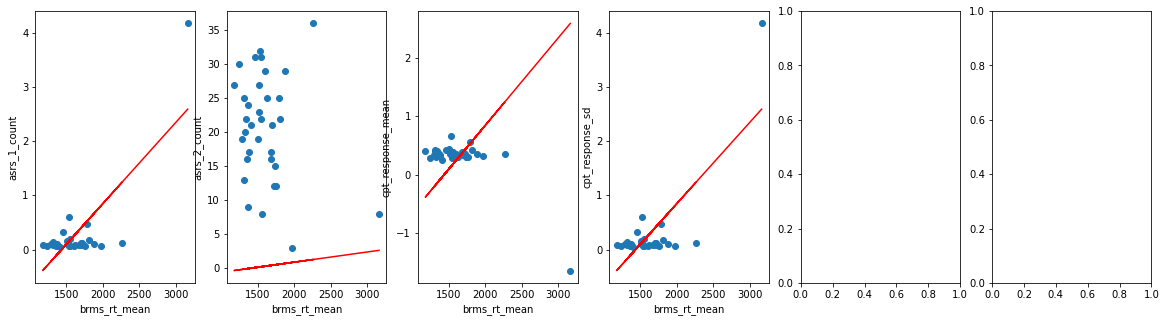

In [ ]:
from sklearn.linear_model import LinearRegression

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(20, 5))

X = result_df.brms_rt_mean.values.reshape(-1, 1)

Y_1 = result_df.asrs_1_count.values.reshape(-1, 1)
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_1_pred = linear_regressor.predict(X)

axes[0].scatter(X, Y)
axes[0].plot(X, Y_pred, color='red')
axes[0].set_xlabel("brms_rt_mean")
axes[0].set_ylabel("asrs_1_count")

Y_2 = result_df.asrs_2_count.values.reshape(-1, 1)
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_2_pred = linear_regressor.predict(X)

axes[1].scatter(X, Y_2)
axes[1].plot(X, Y_2_pred, color='red')
axes[1].set_xlabel("brms_rt_mean")
axes[1].set_ylabel("asrs_2_count")

Y_3 = result_df.cpt_response_mean.values.reshape(-1, 1)
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_3_pred = linear_regressor.predict(X)

axes[2].scatter(X, Y_3)
axes[2].plot(X, Y_3_pred, color='red')
axes[2].set_xlabel("brms_rt_mean")
axes[2].set_ylabel("cpt_response_mean")

Y_4 = result_df.cpt_response_sd.values.reshape(-1, 1)
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_4_pred = linear_regressor.predict(X)

axes[3].scatter(X, Y_4)
axes[3].plot(X, Y_4_pred, color='red')
axes[3].set_xlabel("brms_rt_mean")
axes[3].set_ylabel("cpt_response_sd")

plt.show()

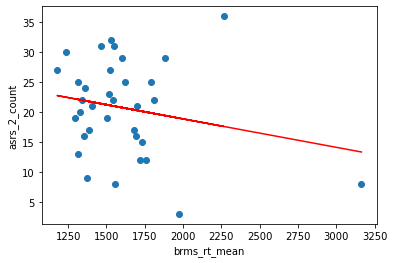

In [ ]:
from sklearn.linear_model import LinearRegression

X = result_df.brms_rt_mean.values.reshape(-1, 1)
Y = result_df.asrs_2_count.values.reshape(-1, 1)
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)

plt.xlabel("brms_rt_mean")
plt.ylabel("asrs_2_count")
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

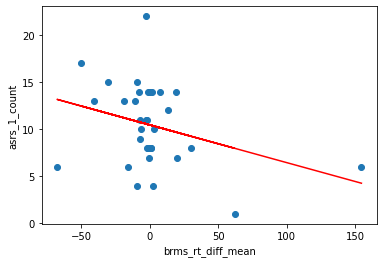

In [ ]:
from sklearn.linear_model import LinearRegression

X = result_df.brms_rt_diff_mean.values.reshape(-1, 1)
Y = result_df.asrs_1_count.values.reshape(-1, 1)
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)

plt.xlabel("brms_rt_diff_mean")
plt.ylabel("asrs_1_count")
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

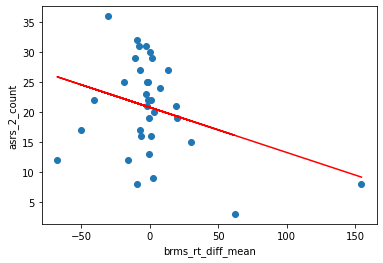

In [ ]:
from sklearn.linear_model import LinearRegression

X = result_df.brms_rt_diff_mean.values.reshape(-1, 1)
Y = result_df.asrs_2_count.values.reshape(-1, 1)
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)

plt.xlabel("brms_rt_diff_mean")
plt.ylabel("asrs_2_count")
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

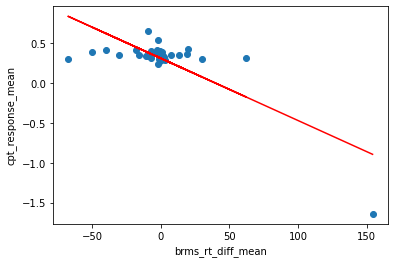

In [ ]:
from sklearn.linear_model import LinearRegression

X = result_df.brms_rt_diff_mean.values.reshape(-1, 1)
Y = result_df.cpt_response_mean.values.reshape(-1, 1)
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)

plt.xlabel("brms_rt_diff_mean")
plt.ylabel("cpt_response_mean")
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

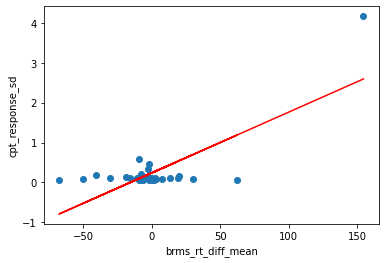

In [ ]:
from sklearn.linear_model import LinearRegression

X = result_df.brms_rt_diff_mean.values.reshape(-1, 1)
Y = result_df.cpt_response_sd.values.reshape(-1, 1)
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)

plt.xlabel("brms_rt_diff_mean")
plt.ylabel("cpt_response_sd")
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

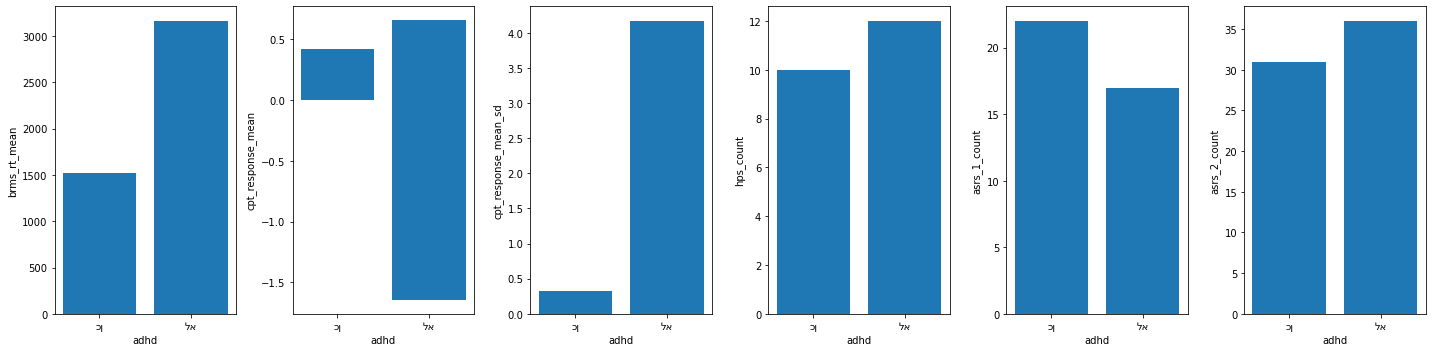

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(20, 5))

axes[0].bar(result_df.adhd, result_df.brms_rt_mean)
axes[0].set_xlabel("adhd")
axes[0].set_ylabel("brms_rt_mean")

axes[1].bar(result_df.adhd, result_df.cpt_response_mean)
axes[1].set_xlabel("adhd")
axes[1].set_ylabel("cpt_response_mean")
fig.tight_layout()

axes[2].bar(result_df.adhd, result_df.cpt_response_sd)
axes[2].set_xlabel("adhd")
axes[2].set_ylabel("cpt_response_mean_sd")
fig.tight_layout()

axes[3].bar(result_df.adhd, result_df.hps_count)
axes[3].set_xlabel("adhd")
axes[3].set_ylabel("hps_count")
fig.tight_layout(),

axes[4].bar(result_df.adhd, result_df.asrs_1_count)
axes[4].set_xlabel("adhd")
axes[4].set_ylabel("asrs_1_count")
fig.tight_layout()

axes[5].bar(result_df.adhd, result_df.asrs_2_count)
axes[5].set_xlabel("adhd")
axes[5].set_ylabel("asrs_2_count")
fig.tight_layout()

plt.show()

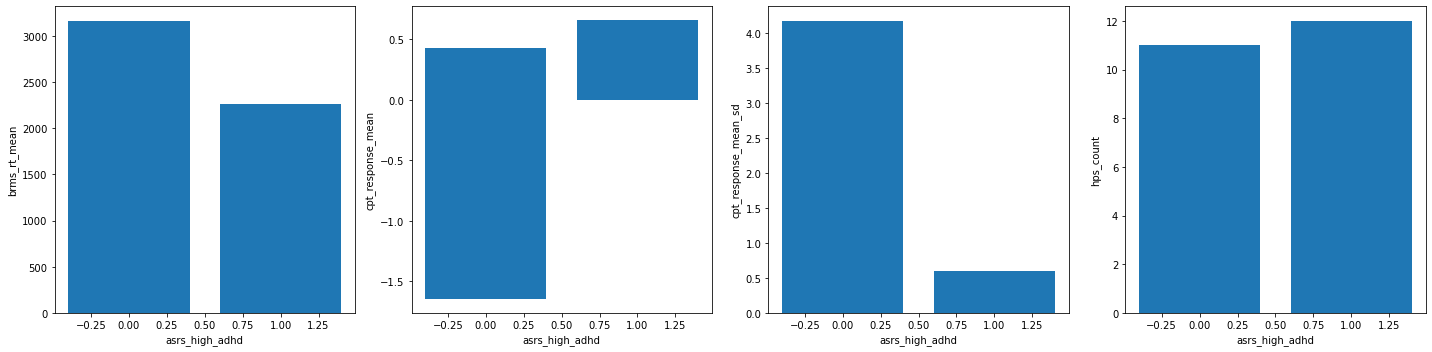

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

axes[0].bar(result_df.asrs_high_adhd, result_df.brms_rt_mean)
axes[0].set_xlabel("asrs_high_adhd")
axes[0].set_ylabel("brms_rt_mean")

axes[1].bar(result_df.asrs_high_adhd, result_df.cpt_response_mean)
axes[1].set_xlabel("asrs_high_adhd")
axes[1].set_ylabel("cpt_response_mean")
fig.tight_layout()

axes[2].bar(result_df.asrs_high_adhd, result_df.cpt_response_sd)
axes[2].set_xlabel("asrs_high_adhd")
axes[2].set_ylabel("cpt_response_mean_sd")
fig.tight_layout()

axes[3].bar(result_df.asrs_high_adhd, result_df.hps_count)
axes[3].set_xlabel("asrs_high_adhd")
axes[3].set_ylabel("hps_count")
fig.tight_layout()

plt.show()

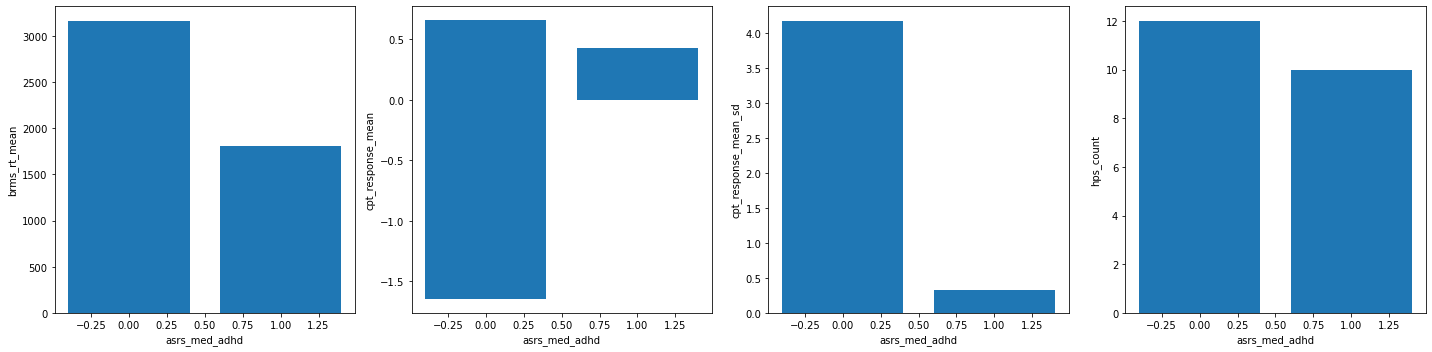

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

axes[0].bar(result_df.asrs_med_adhd, result_df.brms_rt_mean)
axes[0].set_xlabel("asrs_med_adhd")
axes[0].set_ylabel("brms_rt_mean")

axes[1].bar(result_df.asrs_med_adhd, result_df.cpt_response_mean)
axes[1].set_xlabel("asrs_med_adhd")
axes[1].set_ylabel("cpt_response_mean")
fig.tight_layout()

axes[2].bar(result_df.asrs_med_adhd, result_df.cpt_response_sd)
axes[2].set_xlabel("asrs_med_adhd")
axes[2].set_ylabel("cpt_response_mean_sd")
fig.tight_layout()

axes[3].bar(result_df.asrs_med_adhd, result_df.hps_count)
axes[3].set_xlabel("asrs_med_adhd")
axes[3].set_ylabel("hps_count")
fig.tight_layout()

plt.show()

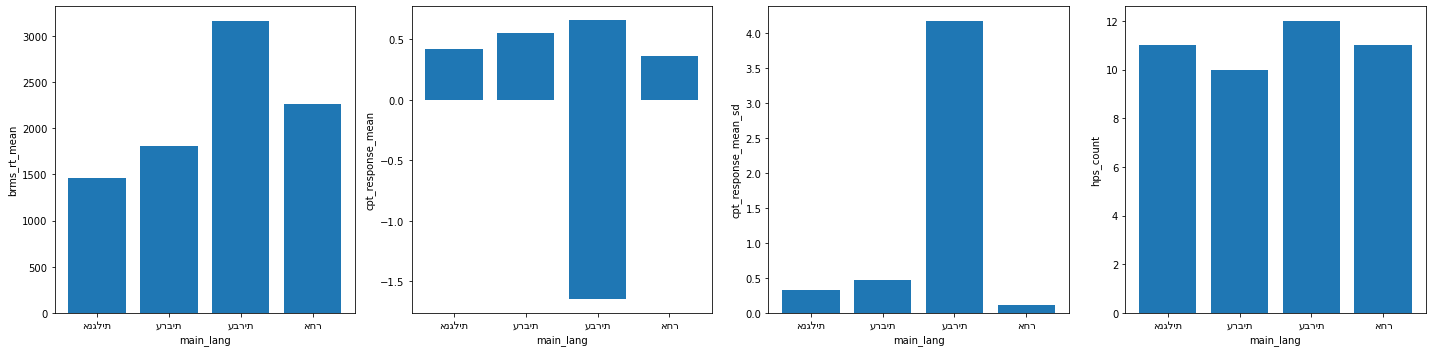

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

axes[0].bar(result_df.main_lang, result_df.brms_rt_mean)
axes[0].set_xlabel("main_lang")
axes[0].set_ylabel("brms_rt_mean")
fig.tight_layout()

axes[1].bar(result_df.main_lang, result_df.cpt_response_mean)
axes[1].set_xlabel("main_lang")
axes[1].set_ylabel("cpt_response_mean")
fig.tight_layout()

axes[2].bar(result_df.main_lang, result_df.cpt_response_sd)
axes[2].set_xlabel("main_lang")
axes[2].set_ylabel("cpt_response_mean_sd")
fig.tight_layout()

axes[3].bar(result_df.main_lang, result_df.hps_count)
axes[3].set_xlabel("main_lang")
axes[3].set_ylabel("hps_count")
fig.tight_layout()

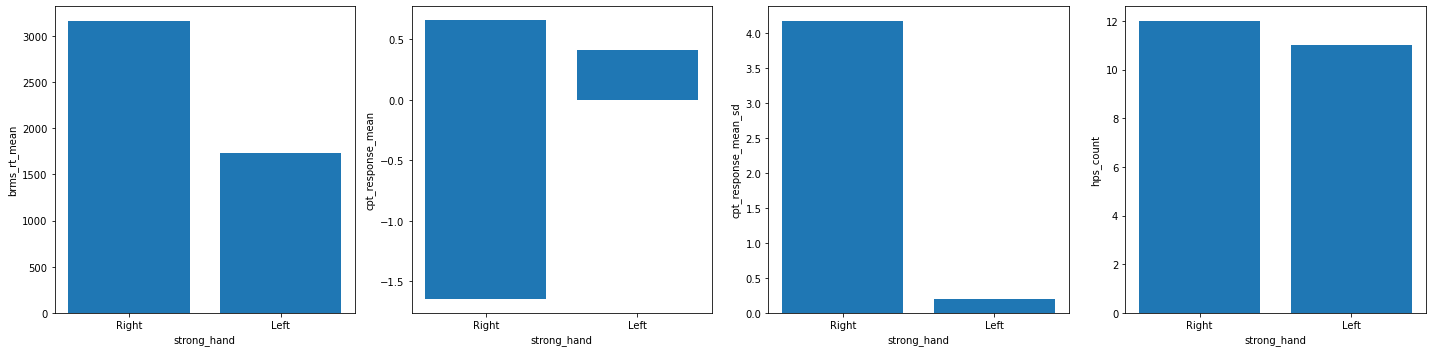

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

axes[0].bar(result_df.strong_hand, result_df.brms_rt_mean)
axes[0].set_xlabel("strong_hand")
axes[0].set_ylabel("brms_rt_mean")
fig.tight_layout()

axes[1].bar(result_df.strong_hand, result_df.cpt_response_mean)
axes[1].set_xlabel("strong_hand")
axes[1].set_ylabel("cpt_response_mean")
fig.tight_layout()

axes[2].bar(result_df.strong_hand, result_df.cpt_response_sd)
axes[2].set_xlabel("strong_hand")
axes[2].set_ylabel("cpt_response_mean_sd")
fig.tight_layout()

axes[3].bar(result_df.strong_hand, result_df.hps_count)
axes[3].set_xlabel("strong_hand")
axes[3].set_ylabel("hps_count")
fig.tight_layout()

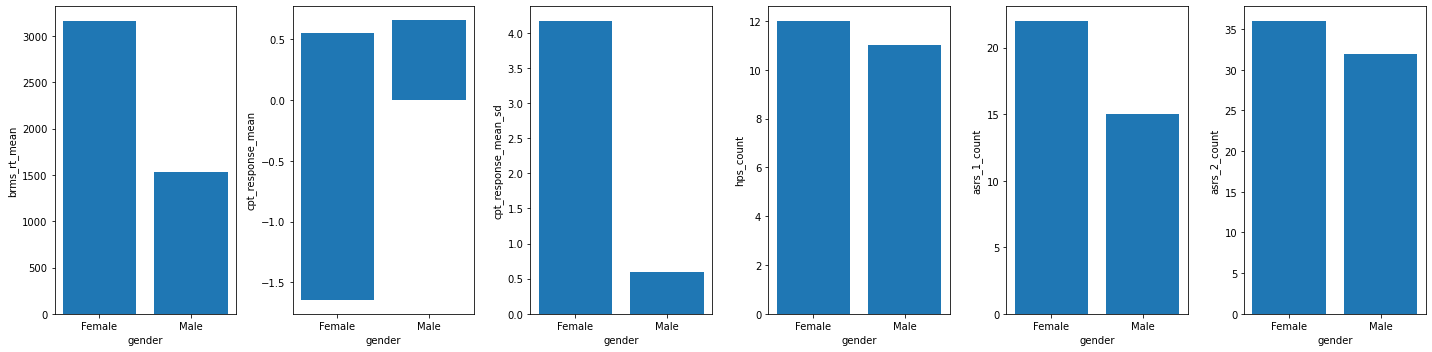

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(20, 5))

axes[0].bar(result_df.gender, result_df.brms_rt_mean)
axes[0].set_xlabel("gender")
axes[0].set_ylabel("brms_rt_mean")

axes[1].bar(result_df.gender, result_df.cpt_response_mean)
axes[1].set_xlabel("gender")
axes[1].set_ylabel("cpt_response_mean")
fig.tight_layout()

axes[2].bar(result_df.gender, result_df.cpt_response_sd)
axes[2].set_xlabel("gender")
axes[2].set_ylabel("cpt_response_mean_sd")
fig.tight_layout()

axes[3].bar(result_df.gender, result_df.hps_count)
axes[3].set_xlabel("gender")
axes[3].set_ylabel("hps_count")
fig.tight_layout(),

axes[4].bar(result_df.gender, result_df.asrs_1_count)
axes[4].set_xlabel("gender")
axes[4].set_ylabel("asrs_1_count")
fig.tight_layout()

axes[5].bar(result_df.gender, result_df.asrs_2_count)
axes[5].set_xlabel("gender")
axes[5].set_ylabel("asrs_2_count")
fig.tight_layout()

plt.show()